In [ ]:
#######################
###  Global paths   ###
#######################
custom_module_path = f'/content/drive/MyDrive/MoA/utilites'
dataset_path = f'/content/drive/MyDrive/MoA/dataset'

#######################
### Library imports ###
#######################
# standard library
import os
import sys
import copy

#custom tooling
sys.path.append(custom_module_path)
import resnet
import preprocess

In [ ]:
import tensorflow as tf

# Configurations

length = 877  # Length of each Segment
model_name = 'ResNet18'  # DenseNet Models
model_width = 64  # Width of the Initial Layer, subsequent layers start from here
num_channel = 1  # Number of Input Channels in the Model
problem_type = 'Classification'  # Classification or Regression
output_nums = 206  # Number of Class for Classification Problems, always '1' for Regression Problems
  
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
  
Model = resnet.ResNet(length, num_channel, model_width, problem_type=problem_type, output_nums=output_nums, pooling='avg',dropout_rate=0.3).ResNet18()
Model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 877, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 439, 64)      512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 439, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 439, 64)      0           ['batch_normalization[0][0]']

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

def split_data(X,y, size_test=0.1):
    X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=size_test, random_state=19)
    return X_tr,X_test,y_tr,y_test 

def preprocess_data(X,y):
    transformer = preprocess.Preprocessor() 
    transformer.fit(X)
    X = transformer.transform(X)
    y = y.drop(["sig_id"], axis = 1).values.astype("float32") 
    return pd.DataFrame(X),pd.DataFrame(y)

drugs = pd.read_csv(f'{dataset_path}/train_drug.csv')
train_drug = pd.read_csv(f'{dataset_path}/train_drug.csv')
X = pd.read_csv(f'{dataset_path}/train_features.csv')
y = pd.read_csv(f'{dataset_path}/train_targets_scored.csv')

X,y = preprocess_data(X,y)
X_train, X_test, y_train, y_test = split_data(X,y)
X_train, X_val, y_train, y_val = split_data(X_train,y_train,0.2)

X_train, X_val = np.array(X_train), np.array(X_val)
y_train, y_val = y_train.values.astype("float32"), y_val.values.astype("float32")

In [ ]:
history = Model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=3, verbose=1)

Epoch 1/3
536/536 [==============================] - 28s 31ms/step - loss: 0.0258 - accuracy: 0.0547 - val_loss: 0.0203 - val_accuracy: 0.0537
Epoch 2/3
536/536 [==============================] - 14s 27ms/step - loss: 0.0179 - accuracy: 0.0870 - val_loss: 0.0194 - val_accuracy: 0.0637
Epoch 3/3
536/536 [==============================] - 15s 27ms/step - loss: 0.0172 - accuracy: 0.0996 - val_loss: 0.0184 - val_accuracy: 0.0742


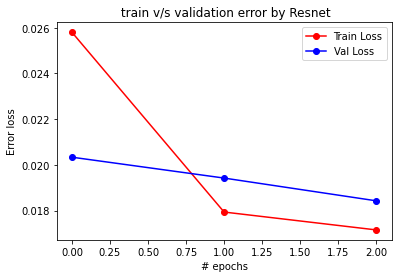

In [ ]:
import matplotlib.pyplot as plt

def plotErrors(train_error, val_error, name='by Resnet'):  
    plt.plot(train_error, color='red', marker='o', label='Train Loss')
    plt.plot(val_error, color='blue', marker='o', label='Val Loss')
    plt.title(f' train v/s validation error {name}')
    plt.xlabel('# epochs')
    plt.ylabel('Error loss') 
    plt.legend(loc="upper right")
    plt.show()

plotErrors(history.history['loss'],history.history['val_loss'])

In [ ]:
from sklearn.metrics import f1_score

def predict_proba(preds):
    preds_proba = 1 / (1 + np.exp(-preds))
    return preds_proba.astype("float32")

def get_f1_score(model, X_test, y_test):
    y_predict = np.argmax(model.predict(X_test), axis=1) 
    y_true = np.argmax(y_test.values.astype("float32"),axis=1)
    mf1 = f1_score(y_true, y_predict,average='weighted')
    return mf1 

get_f1_score(Model,X_test, y_test)

75/75 [==============================] - 1s 8ms/step


0.03661573646729219

75/75 [==============================] - 1s 8ms/step


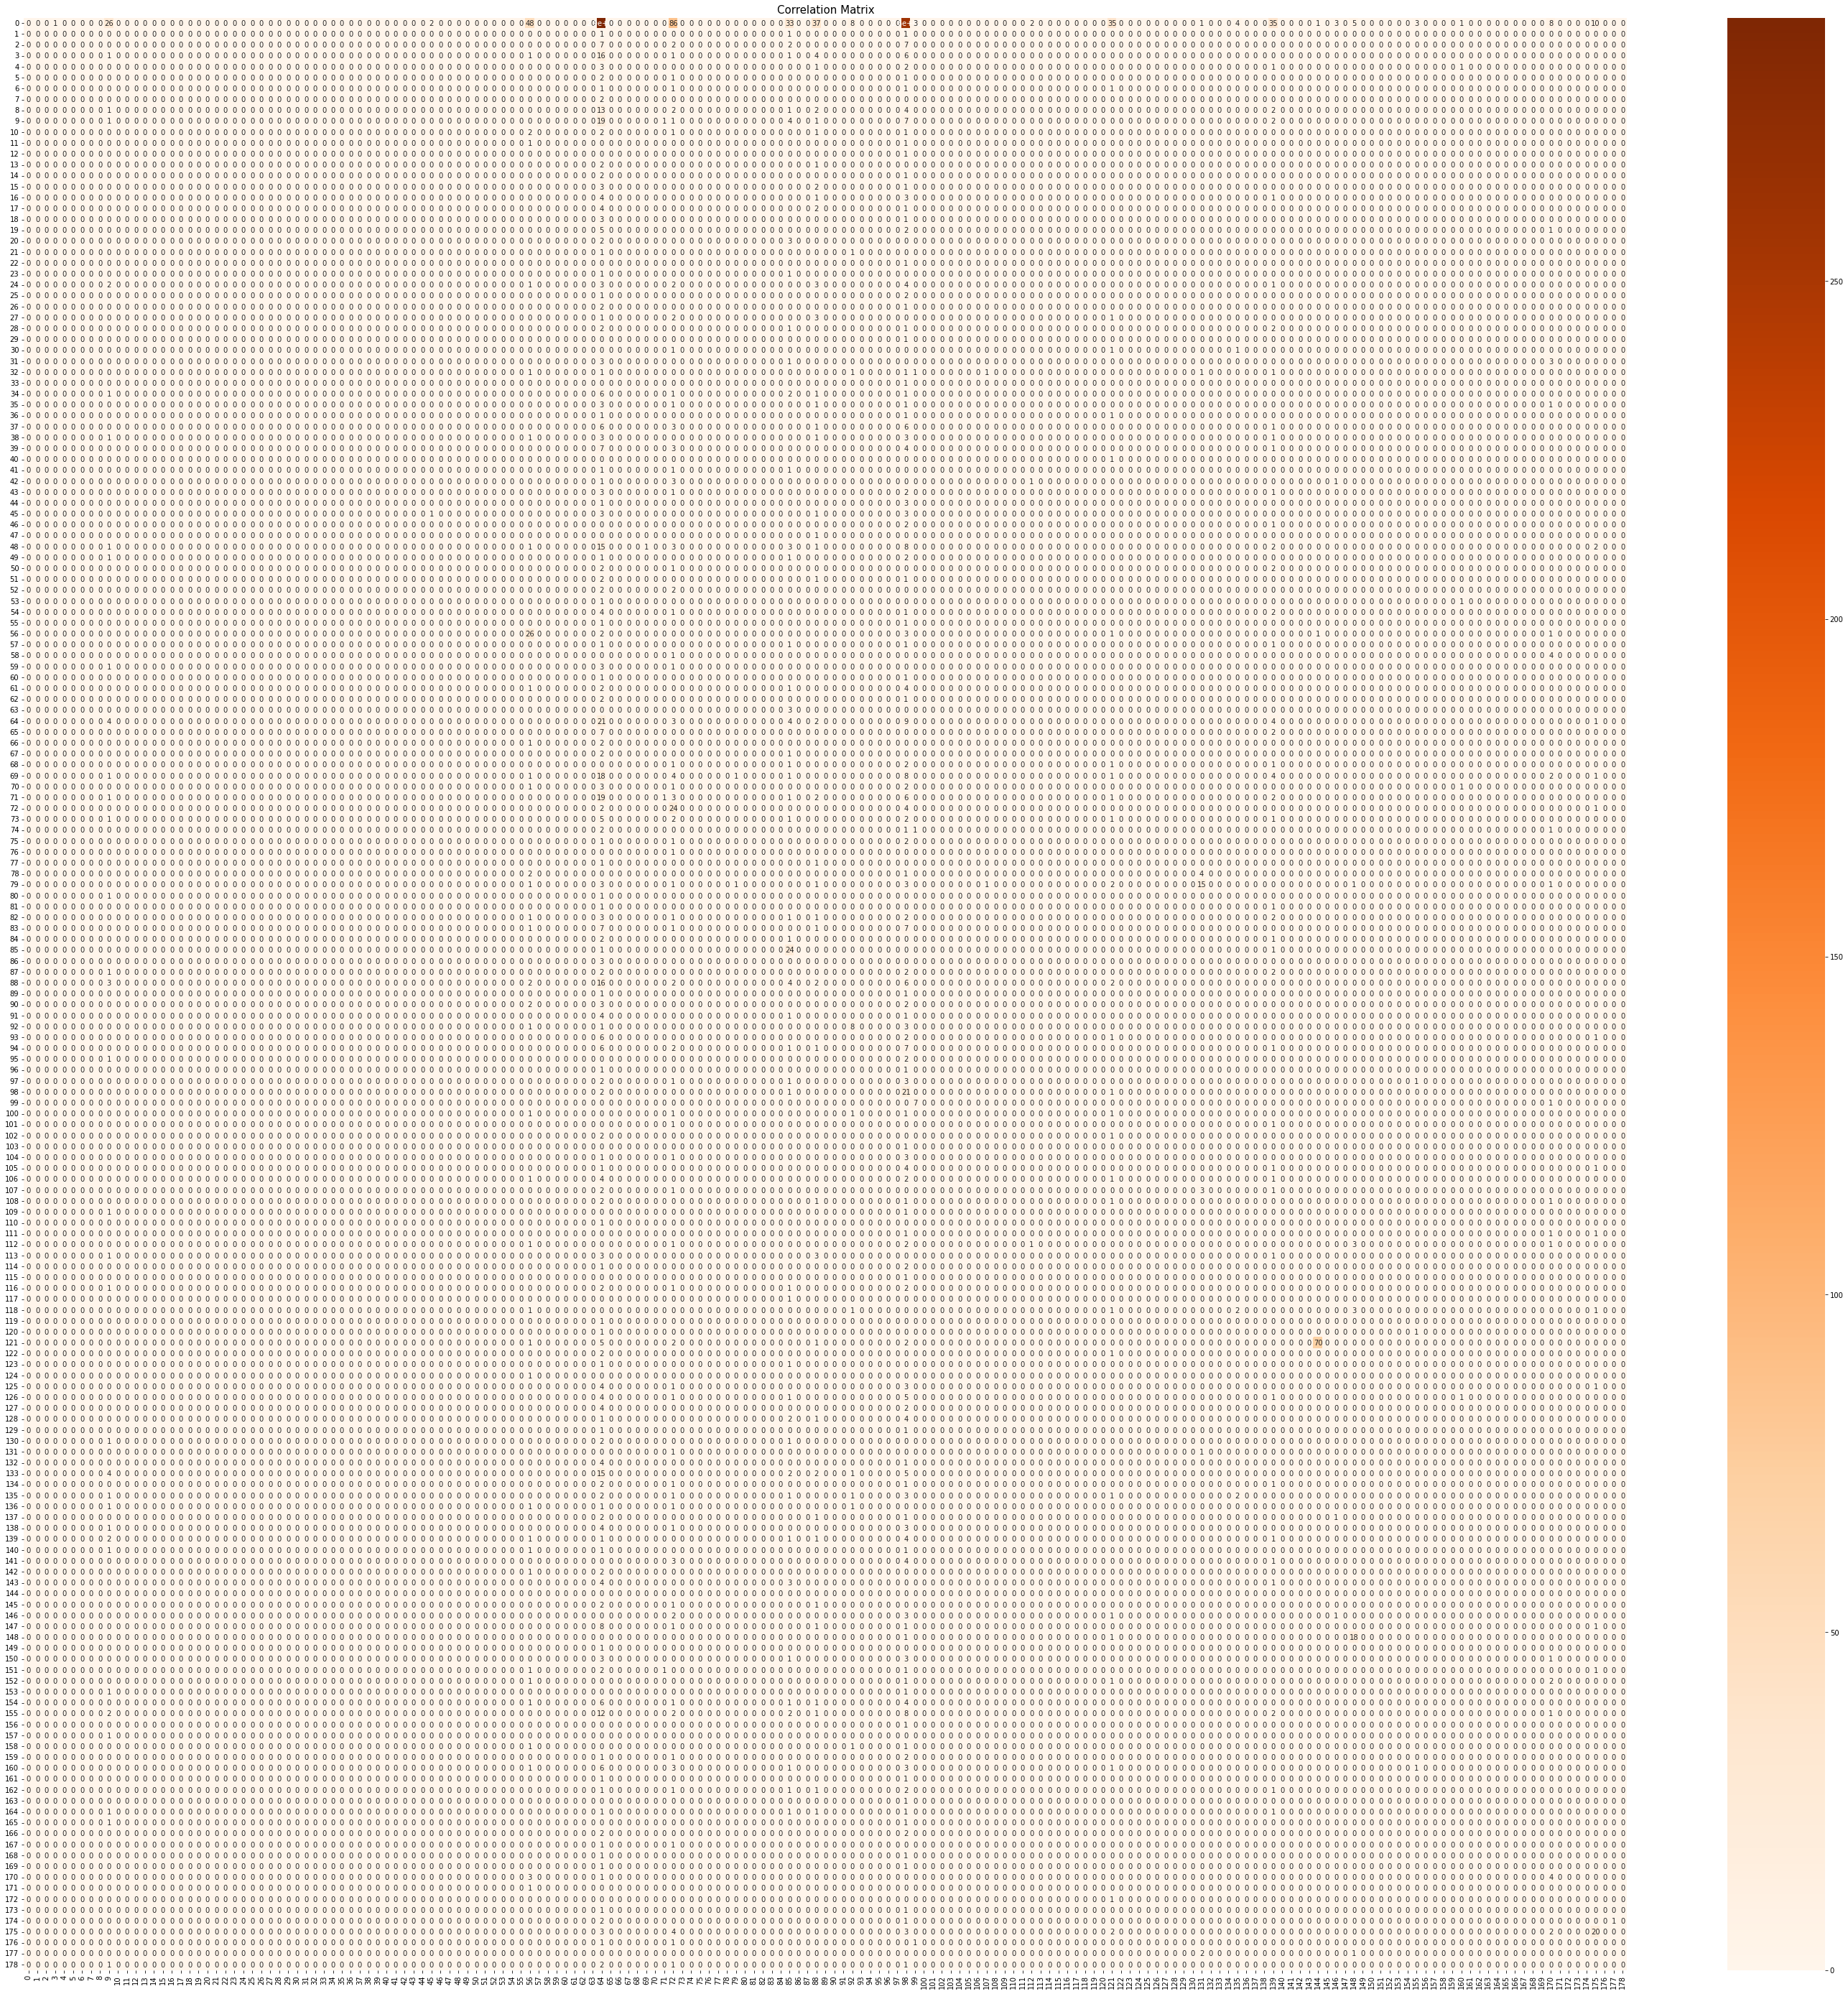

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_cm (model, X_test, y_test):
    y_predict = np.argmax(model.predict(X_test), axis=1) 
    y_true = np.argmax(y_test.values.astype("float32"),axis=1)

    confm = confusion_matrix(y_true, y_predict)
    df_cm = pd.DataFrame(confm)
    return df_cm

df_cm = get_cm(Model,X_test, y_test)

fig= plt.figure(figsize=(50,50))
ax= fig.add_subplot(111)
ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title("Correlation Matrix", fontsize = 15)
plt.show()